# Gibbs sampling for joint inference of transmission network and infection times

Sergio Bacallado, 3/6/2020

In [646]:
import numpy as np
from scipy.stats import gamma
import scipy
import copy
import cPickle

In [549]:
class Tree:
    """Represents a tree rooted at 0 where each node's parent is constrained
    to be in some set. Cases adjacent to the root are index cases.
    
    """
    def __init__(self,n,possibleParents):
        self.n = n # Number of nodes (not including root)
        self.possibleParents = possibleParents # A dict of possible parents for each node
        self.Initialise()
        
    def Reset(self):
        """Generates the data structures for parent, child.
        
        """
        self.parent = {i: 0 for i in range(1,self.n+1)}
        self.child = {i: set() for i in range(self.n+1)}
        self.descendant = {i: set() for i in range(self.n+1)}
    
    def AssignNodes(self):
        growth = 1
        while growth > 0:
            bef = len(self.assigned)
            for v in set(range(1,self.n+1)).difference(self.assigned):
                parentsAssigned =  set(self.possibleParents[v]).intersection(self.assigned)
                if len(parentsAssigned)>0:
                    w = np.random.choice(list(parentsAssigned))
                    self.parent[v] = w
                    self.child[w].add(v)
                    self.assigned.add(v)
            growth = len(self.assigned)-bef
    
    def Initialise(self):
        """ Initialises the infection network such that there are no cycles.
        
        """
        x = np.random.permutation(self.n)
        self.Reset()
        self.assigned = set()
        # Add all the sure index cases to assigned
        for v in range(1,self.n+1):
            if len(self.possibleParents[v])==1 and (0 in self.possibleParents[v]):
                self.parent[v] = 0
                self.child[0].add(v)
                self.assigned.add(v)
        # Assign parents to cases iteratively from those already assigned
        self.AssignNodes()
        while len(self.assigned)<self.n:
            v = np.random.choice(list(set(range(1,self.n+1)).difference(self.assigned)))
            self.parent[v] = 0
            self.child[0].add(v)
            self.assigned.add(v)
            self.AssignNodes()
        self.ComputeDescendants()
        if self.HasCycle():
            print("Failed to build a tree!")
    
    def ComputeDescendants(self,v=0):
        """ From the parents and children dictionaries, compute descendant diccionary
        for a given node v.
        
        """
        self.descendant[v] = set()
        for c in self.child[v]:
            self.descendant[v].add(c)
            self.descendant[v].update(self.ComputeDescendants(c))
        return self.descendant[v]
            
    def HasCycle(self):
        """Checks if directed graph structure in self.parent has cycle.
        
        """
        if self.parent=={}:
            return True
        for v in xrange(self.n+1):
            if not self.GetsTo(v,0)[0]:
                return True
        return False
    
    def GetsTo(self,v,w,k=None):
        """Checks whether there is a directed path from v to w of length<=k, outputs 
        True or False, and if true, the distance between the nodes.
        
        """
        if k == None:
            k = self.n+2
        if v == w:
            return (True, 0)
        if k == 0:
            return (False, None)
        x,y = self.GetsTo(self.parent[v],w,k-1)
        return ((x,y+1) if x else (x,None)) 
    
    
    def AllowedParents(self,v):
        """ Returns possible parents of v who are not currently descendants of v.
        
        """
        return set(self.possibleParents[v]).difference(self.descendant[v])
    
    def ProposeMove(self):
        """Proposes a move to a new tree by reassigning the parent of one node uniformly
        at random. Returns the new tree, the ratio of probabilities of the forward and 
        backward moves, the node changing parents, and the two parents.
        
        """
        moveableNode = np.arange(1,self.n+1)
        moveableNode = moveableNode[[len(self.possibleParents[v])>1 for v in moveableNode]]
        allowedParents = set()
        while len(allowedParents)<2:
            v = np.random.choice(moveableNode)
            allowedParents = self.AllowedParents(v)
        oldPa = self.parent[v]
        newPa = np.random.choice(list(allowedParents.difference([oldPa])))
        newT = copy.deepcopy(self)
        newT.parent[v] = newPa
        newT.child[oldPa].remove(v)
        newT.child[newPa].add(v) 
        newT.ComputeDescendants()
        ratio = float(len(newT.AllowedParents(v))-1)/float(len(allowedParents)-1)
        return newT, ratio, v, self.parent[v], newT.parent[v]
    
    def Level(self,v):
        """ Returns the distance from v to root 0.
        
        """
        return self.GetsTo(v,0)[1]

In [550]:
class Params:
    def __init__(self,a1,b1,a2,b2):
        self.a1 = a1
        self.b1 = b1
        self.a2 = a2
        self.b2 = b2

In [551]:
def OrderViolated(S,I,T):
    """ Check whether the order of infection and symptom onset is violated in the
    triple S,I,T.
    
    """
    for v in range(1,n+1):
        if min([S[v]]+[S[w]-1 for w in T.child[v]]) - I[T.parent[v]] < 2:
            return True,v
    return False,-1

def InitialiseI(S,I,T):
    """ Initialises the infection times I given symptom onset S and tree T.
    
    """
    for v in range(1,n+1):
        I[v] = min([S[v]]+[S[w]-1 for w in T.child[v]]) - 1
    cond,v = OrderViolated(S,I,T)
    while cond:
        I[T.parent[v]] += -1
        cond,v = OrderViolated(S,I,T)

In [605]:
def GibbsSampler(T,I,params,S,nIter,saveInt,maxTime=30):
    n = T.n
    samples = []
    for i in xrange(nIter):
        print("Iteration %i"%i)
        # Determine nodes an even or odd distance from 0
        levels = np.array([T.Level(v) for v in range(n+1)])  # Get level for each node
        oddLevels = (levels%2==1)
        evenLevels = (levels%2==0)
        #print S-I
        # Update I_v for odd nodes
        post = GetPost(T,I,params,S,maxTime)
        newI = (post.cumsum(0) < np.random.rand(post.shape[1])).argmin(0)
        I[oddLevels] = newI[oddLevels]
        # Update I_v for even nodes
        post = GetPost(T,I,params,S,maxTime)  
        newI = (post.cumsum(0) < np.random.rand(post.shape[1])).argmin(0)
        I[evenLevels] = newI[evenLevels]
        # Resample tree
        for _ in xrange(10):
            newT,ratio,v,w1,w2 = T.ProposeMove()
            if I[v]-I[w2] < 0:    # Don't accept moves that have parent infected before child
                continue
            acc = np.exp(LogGenerationLik(I[v]-I[w2],params)-LogGenerationLik(I[v]-I[w1],params))/ratio
            if np.random.rand() < acc:
                T = newT
                #print("accepted")
        # Update parameters
        for _ in xrange(10):
            params = UpdateParams(T,I,S,params)
        # Trace sample
        if i%saveInt==1:
            samples.append([T,I,params])
    return samples
        
def LogGenerationLik(x,params):
    return gamma.logpdf(x,params.a1,scale=1/params.b1)
    
def LogIncubationLik(x,params):
    return gamma.logpdf(x,params.a2,scale=1/params.b2)
    
def UpdateParams(T,I,S,params):
    """ Metropolis-Hastings step for the parameters.
    
    """
    scale = 0.3
    newParams = copy.deepcopy(params)
    newParams.a1 = params.a1 + scale * (np.random.rand() -0.5)
    newParams.b1 = params.b1 + scale * (np.random.rand() -0.5)
    if (newParams.a1 < 0) or (newParams.b1 < 0):
        return params
    notIndex = np.array([False]+[T.parent[v]!=0 for v in range(1,T.n)])
    genInts = [I[v]-I[T.parent[v]] for v in np.arange(T.n)[notIndex]]
    acc = sum(LogGenerationLik(genInts,newParams))
    acc += -sum(LogGenerationLik(genInts,params))
    if np.random.rand() < np.exp(acc):
        #print("accepted params")
        return newParams
    else:
        return params
    
def LogPostForI(v,t,T,I,params,S):
    return LogIncubationLik(S[v]-t,params) \
            + (LogGenerationLik(t-I[T.parent[v]],params) if T.parent[v]!=0 else 0.0 ) \
            + sum(LogGenerationLik(I[w]-t,params) for w in T.child[v])
    
def GetPost(T,I,params,S,maxTime=30):
    """ Outputs a (maxTime x n+1) array storing for each node v (column), 
    the factors of the posterior depending on I[v], for every possible
    assignment of I[v] (row).
    
    """
    logpost = np.zeros((T.n+1,maxTime))
    logpost[1:,:] = -np.inf
    for v in xrange(1,T.n+1):
        t1 = I[T.parent[v]] if T.parent[v] != 0 else -1
        t2 = min([S[v]]+[I[w] for w in T.child[v]]) 
        for t in xrange(int(t1)+1,int(t2)):
            logpost[v,t] = LogPostForI(v,t,T,I,params,S) 
    logpost = np.transpose(logpost)
    #print logpost.max(0)
    logpost += -logpost.max(0)
    post = np.exp(logpost)
    return post/post.sum(0)

## Run MCMC chain

In [606]:
np.random.seed(1)

possibleInfector = np.genfromtxt("PossibleInfector.csv",delimiter=",",dtype=int)
S = np.loadtxt("SymptonOnsetTimes.csv",skiprows=1)

n = possibleInfector.shape[0]
# Fix mistake in dataset: Cases 40,41,42 don't have a possible parent outside the set {40,41,42}, 
# so they always form a cycle. We add the possibility that each of them is an index case.
possibleInfector[39,3] = 0
possibleInfector[40,3] = 0
possibleInfector[41,3] = 0
possibleParents = {i+1: possibleInfector[i,~(possibleInfector[i,:]==-1)] for i in range(n)}
T = Tree(n,possibleParents)
S = S+14                           # Shift symptom onset times so that the first patient shows symptoms on day 14
                                   # we'll consider the earliest possible infection time to be 0.
maxTime = int(max(S))              # The maximum infection time will be the maximum symptom onset time
I = np.zeros(n+1)                  # Length of S and I should be n+1, first element in each is irrelevant
S = np.concatenate([np.zeros(1),S])
# Initialise infection times  
InitialiseI(S,I,T)
# Initialise parameters
params = Params(3.45,0.66,3.45,0.66)

In [ ]:
#%%timeit -n 1 -r 1
samples = GibbsSampler(T,I,params,S,3000,10,maxTime)

In [648]:
cPickle.dump(samples,open("MCMC_output.pkl","wb"))

## Analysis of MCMC traces

Plot traces for the mean and SD of the generating interval distribution.

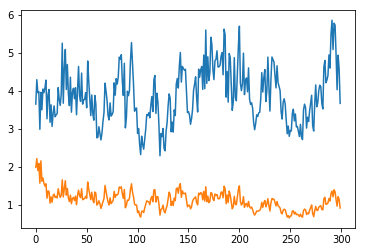

In [611]:
a1 = [samples[i][-1].a1 for i in range(len(samples))]
b1 = [samples[i][-1].b1 for i in range(len(samples))]
meanGen = [samples[i][-1].a1/samples[i][-1].b1 for i in range(len(samples))]
sdGen = [np.sqrt(samples[i][-1].a1)/samples[i][-1].b1 for i in range(len(samples))]
plt.plot(meanGen)
plt.plot(sdGen)

In [645]:
qs = scipy.stats.mstats.mquantiles(meanGen[150:],[0.025,0.975])
"Mean of GI: %.3f (%.3f - %.3f)"%(mean(meanGen[150:]),qs[0],qs[1])

'Mean of GI: 4.072 (2.814 - 5.691)'

## Posterior predictive checks

Below is a posterior predictive check for the empirical SD of the serial intervals.

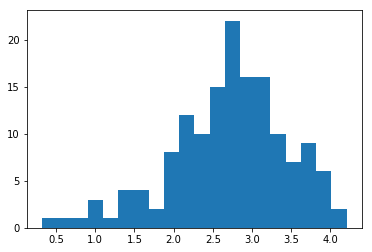

In [643]:
# Discretised distribution of incubation period
p = gamma.pdf(range(1,31),params.a2,scale=1/params.b2)
p = p/sum(p)

diff = []
for i in range(150,len(samples)):
    T = samples[i][0]
    realSerialInts = np.array([S[v]-S[T.parent[v]] for v in range(1,n+1)])
    I = samples[i][1]
    Srep = I + np.random.choice(range(1,31),size=len(I),p=p)
    replSerialInts = np.array([Srep[v]-Srep[T.parent[v]] for v in range(1,n+1)])
    diff.append(np.std(realSerialInts)-np.std(replSerialInts))
    
_ = plt.hist(diff,bins=20)

Below is a posterior predictive check for the proportion of negative serial intervals (pre-symptomatic transmissions).

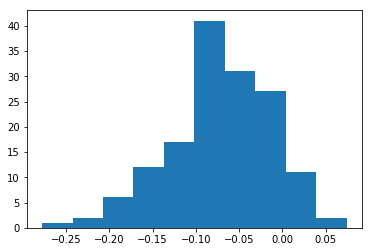

In [641]:
# Discretised distribution of incubation period
p = gamma.pdf(range(1,31),params.a2,scale=1/params.b2)
p = p/sum(p)

diff = []
for i in range(150,len(samples)):
    T = samples[i][0]
    realSerialInts = np.array([S[v]-S[T.parent[v]] for v in range(1,n+1)])
    I = samples[i][1]
    Srep = I + np.random.choice(range(1,31),size=len(I),p=p)
    replSerialInts = np.array([Srep[v]-Srep[T.parent[v]] for v in range(1,n+1)])
    diff.append(np.mean(realSerialInts<0)-np.mean(replSerialInts<0))
    
_ = plt.hist(diff,bins=10)